In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
import glob
import os.path as osp
import numpy as np
from PIL import Image

In [2]:
class MOVIES(Dataset):

# A customized data loader for MNIST.\n",
    def __init__(self, root,transform=None,preload=False):
#             Intialize the MNIST dataset,
#             Args:,
#                 - root: root directory of the dataset
#                 - transform: a custom tranform function
#                 - preload: if preload the dataset into memory
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform
            
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.jpg'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label)

        # if preload dataset into memory",
        if preload:
            self._preload()

        self.len = len(self.filenames)

    def _preload(self):

#        Preload dataset to memory

        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            self.labels.append(label)

    def __getitem__(self, index):
#              Get a sample from the dataset

        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)

        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):

#             Total number of samples in the dataset
        return self.len

In [3]:
data_transforms = transforms.Compose([
        transforms.Resize((28,28)),
#         transforms.RandomResizedCrop(28),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize([R_Mean, G_Mean, B_Mean], [R_std, G_Std, B_Std])
    ])

In [5]:
trainset = MOVIES(root='datasets/split_drama_posters/train/', preload=False, transform=data_transforms)
# Use the torch dataloader to iterate through the dataset
# trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)
trainset_loader = DataLoader(trainset, shuffle=True, num_workers=1)

# load the testset
testset = MOVIES(
    root='datasets/split_drama_posters/test/',
    preload=False, transform=transforms.ToTensor(),
)
# # Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [6]:
trainset[0][1]

0

In [7]:
print(len(trainset))
# print(len(testset))

4294


tensor(1)


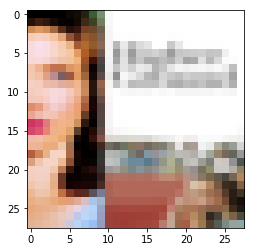

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(1)))

In [10]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device(cuda if use_cuda else "cpu")
print(device)

cpu


In [11]:
# for i,each in enumerate(trainset):
#     if i%100==0:
#         print(i)
#     if each[0].shape[0] != 3 or each[0].shape[1] != 28 or each[0].shape[2] != 28:
#         print(i,each)

In [12]:
# #elephantman
# print(trainset[878][0].shape)
# print(trainset[878][1])
# print(trainset[4203][0].shape)
# print(trainset[4203][1])


# print(trainset[4289][0].shape)
# print(trainset[4289][1])

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
def train(epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        test()

In [15]:
def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

In [16]:
train(1)  # train 5 epochs should get you to about 97% accuracy

Train Epoch: 0 [0/4294 (0%)]	Loss: 0.573998
Train Epoch: 0 [100/4294 (2%)]	Loss: 0.620547
Train Epoch: 0 [200/4294 (5%)]	Loss: 0.837610
Train Epoch: 0 [300/4294 (7%)]	Loss: 0.645405
Train Epoch: 0 [400/4294 (9%)]	Loss: 0.629780
Train Epoch: 0 [500/4294 (12%)]	Loss: 0.606100
Train Epoch: 0 [600/4294 (14%)]	Loss: 0.611902
Train Epoch: 0 [700/4294 (16%)]	Loss: 0.658753
Train Epoch: 0 [800/4294 (19%)]	Loss: 0.760477
Train Epoch: 0 [900/4294 (21%)]	Loss: 0.755285
Train Epoch: 0 [1000/4294 (23%)]	Loss: 0.634080
Train Epoch: 0 [1100/4294 (26%)]	Loss: 0.834025
Train Epoch: 0 [1200/4294 (28%)]	Loss: 0.710429
Train Epoch: 0 [1300/4294 (30%)]	Loss: 0.555280
Train Epoch: 0 [1400/4294 (33%)]	Loss: 0.584127
Train Epoch: 0 [1500/4294 (35%)]	Loss: 0.628395
Train Epoch: 0 [1600/4294 (37%)]	Loss: 0.595649
Train Epoch: 0 [1700/4294 (40%)]	Loss: 0.633261
Train Epoch: 0 [1800/4294 (42%)]	Loss: 0.680240
Train Epoch: 0 [1900/4294 (44%)]	Loss: 0.643093
Train Epoch: 0 [2000/4294 (47%)]	Loss: 0.645482
Train Epo

RuntimeError: DataLoader worker (pid 5347) is killed by signal: Killed.

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
test()

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, 500, 100)

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

In [ ]:
# What's in a state dict?
print(model.state_dict().keys())

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model = Net().to(device)
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(1)  # training 1 epoch will get you to 93%!

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model.load_state_dict(model_state)

In [ ]:
train(1)  # training 1 epoch will get you to 93%!